In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import re
import warnings
warnings.filterwarnings("ignore")

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve,
                             confusion_matrix)

In [85]:
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize
from gensim.models import LdaModel
from gensim.test.utils import datapath
import pymorphy2

In [3]:
news = pd.read_csv("materials.csv")
print(news.shape)
news.head()

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


In [4]:
news.iloc[123]['title']

'Бывший главный тренер «Спартака» Олег Романцев поделился мнением о работе Валерия Карпина на посту наставника красно-белых.n«В команде собраны отличные футболисты. Практически каждое место занимает член какой-либо национальной сборной, — приводит слова РоманцеваnSportboxn. — Но вместе они относятся к себе и к команде безответственно. Думаю, пришло время спросить с них. Очень много тактических промахов — практически все игроки ошибаются. Можно посчитать, если каждый пять раз за сезон ошибется, это уже 20 пропущенных мячей.nВалерию нужно немного настойчивее внушать свое видение. Я бывал на предматчевых установках и видел, что работа ведется в правильном направлении. Тренерские идеи доносятся до футболистов, однако, выходя на поле, они почему-то многое забывают».'

In [5]:
users = pd.read_csv("users_articles.csv")
users.head(1)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"


In [6]:
stopword_ru = []
with open('stopwords.txt', encoding="utf-8") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

625

In [7]:
stopword_ru[20:30]

['ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее']

In [8]:
def clean_text(text):
    
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

In [9]:
cache = {}
morph = pymorphy2.MorphAnalyzer()

In [10]:
def lemmatization(text):    
    
    if not isinstance(text, str):
        text = str(text)
    
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-':
            w = w[1:]
        if len(w) > 1:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru]
    
    return words_lem_without_stopwords

In [11]:
morph = pymorphy2.MorphAnalyzer()
morph.parse('выиграли')[0].normal_form

'выиграть'

In [150]:
news['title'].iloc[:5].apply(lambda x: clean_text(x))

0    'заместитель' 'председатель' 'правительство' '...
1    'матч' 'финал' 'кубок' 'россия' 'футбол' 'прио...
2    'форвард' 'авангард' 'томаш' 'заборский' 'прок...
3    'главный' 'тренер' 'кубань' 'юрий' 'красножани...
4    'решение' 'попечительский' 'совет' 'владивосто...
Name: title, dtype: object

In [13]:
tqdm.pandas()
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:38<00:00, 693.05it/s]


In [14]:
%%time
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████████████████████████████████████████████| 27000/27000 [04:43<00:00, 95.15it/s]

CPU times: total: 4min 41s
Wall time: 4min 43s


In [15]:
texts = list(news['title'].values)
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [16]:
common_dictionary.doc2bow(['игра', 'футбол', 'очки', 'травма'],
                          allow_update=True)

[(123, 1), (134, 1), (369, 1), (2670, 1)]

In [18]:
%%time
n_topic = 20
lda = LdaModel(common_corpus, num_topics=n_topic, id2word=common_dictionary,
               passes=10)

CPU times: total: 5min 24s
Wall time: 5min 26s


In [19]:
temp_file = datapath("model.lda")
lda.save(temp_file)

In [20]:
lda = LdaModel.load(temp_file)

In [28]:
other_texts = list(news['title'].iloc[60:62])
common_dictionary = Dictionary(other_texts)
print(other_texts[0])

['нападать', 'сборная', 'бразилия', 'неймара', 'поделиться', 'впечатление', 'финальный', 'матч', 'кубок', 'конфедерация', 'против', 'команда', 'испания', 'летний', 'футболист', 'автор', 'гол', 'изначально', 'победа', 'многий', 'восприниматься', 'нечто', 'невозможный', 'приводить', 'неймара', 'bbc', 'вещь', 'невозможный', 'бог', 'команда', 'показать', 'очень', 'хороший', 'игра', 'осчастливить', 'многий', 'каждый', 'футболист', 'хотеться', 'сыграть', 'финал', 'против', 'хороший', 'команда', 'мир', 'состав', 'столько', 'замечательный', 'футболист']


In [31]:
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]
unseen_doc = other_corpus[1]
lda[unseen_doc] 

[(0, 0.7941912), (1, 0.04075283), (14, 0.12956905)]

In [32]:
x = lda.show_topics(num_topics=n_topic, num_words=15, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: глава россия банк александр москва директор совет владимир правительство доллар министр сергей дмитрий московский миссия
topic_1: гражданин фонд область власть источник сотрудник государственный ru газета размер служба задержать центр лицо орган
topic_2: пациент городской билет предупредить ресторан транспорт майкл джеймс визовый стресс fo повышаться доставлять спешить турок
topic_3: памятник производитель офицер мышь одежда исторический арбитраж кг сооружение архитектор надпись русь дания достопримечательность молдавия
topic_4: газ китай северный китайский японский япония европа корея польша германия южный россия таиланд польский золото
topic_5: произойти тело взрыв двигатель инцидент причина жертва аэропорт испытание штат авария катастрофа пилот машина изз
topic_6: всё жизнь день очень журнал большой первый сделать женщина помощь мозг смерть газета друг жить
topic_7: дом место пострадать данные местный летний убийство сотрудник квартира житель торговый улица москва налог муж

In [35]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(n_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [36]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.83950716, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [40]:
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(n_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(n_topic)]]
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.839507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4896,0.762486,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,...,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501
2,4897,0.806094,0.000000,0.000000,0.000000,0.000000,0.000000,0.103737,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4898,0.675696,0.000000,0.000000,0.000000,0.000000,0.000000,0.174079,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4899,0.671896,0.017269,0.017269,0.017269,0.017269,0.017269,0.017269,0.017269,0.017269,...,0.017269,0.017269,0.017269,0.017269,0.017269,0.017269,0.017269,0.017269,0.017269,0.017269


In [41]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [42]:
doc_dict = dict(zip(topic_matrix['doc_id'].values,
                    topic_matrix[[f'topic_{i}' for i in range(n_topic)]].values))

In [45]:
doc_dict[111]

array([0.52493399, 0.02500347, 0.02500347, 0.02500347, 0.02500347,
       0.02500347, 0.02500347, 0.02500347, 0.02500347, 0.02500347,
       0.02500347, 0.02500347, 0.02500347, 0.02500347, 0.02500347,
       0.02500347, 0.02500347, 0.02500347, 0.02500347, 0.02500347])

In [153]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0) 
    return user_vector

In [154]:
user_articles_list = users['articles'].iloc[12]
get_user_embedding(user_articles_list, doc_dict)

array([0.52496314, 0.05      , 0.05      , 0.05      , 0.52499646,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.52475595, 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ])

In [155]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(n_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(n_topic)]]
user_embeddings.head()

CPU times: total: 172 ms
Wall time: 184 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.762491,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
1,u108690,0.826146,0.092022,0.050000,0.050000,0.157716,0.050000,0.050000,0.050000,0.165117,...,0.050000,0.050000,0.080774,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
2,u108339,0.881237,0.025002,0.025002,0.025002,0.025002,0.025002,0.025002,0.025002,0.025002,...,0.025002,0.025002,0.025002,0.025002,0.170749,0.025002,0.025002,0.025002,0.025002,0.025002
3,u101138,0.817167,0.050000,0.050000,0.050000,0.050000,0.050000,0.155053,0.050000,0.050000,...,0.050000,0.050000,0.181213,0.050000,0.050000,0.050000,0.099980,0.050000,0.050000,0.050000
4,u108248,0.809992,0.025003,0.025003,0.025003,0.210130,0.025003,0.025003,0.025003,0.025003,...,0.025003,0.025003,0.025003,0.025003,0.025003,0.025003,0.025003,0.025003,0.025003,0.025003


In [156]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [157]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.762491,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
1,u108690,0.826146,0.092022,0.050000,0.050000,0.157716,0.050000,0.050000,0.050000,0.165117,...,0.050000,0.080774,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,1
2,u108339,0.881237,0.025002,0.025002,0.025002,0.025002,0.025002,0.025002,0.025002,0.025002,...,0.025002,0.025002,0.025002,0.170749,0.025002,0.025002,0.025002,0.025002,0.025002,1


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(n_topic)]], 
                                                    X['churn'], random_state=16, stratify=X['churn'], 
                                                    test_size=0.3)

In [159]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [160]:
preds = lr.predict_proba(X_test)[:, 1]
preds[:20]

array([0.12261923, 0.06655358, 0.07953949, 0.06162164, 0.08151758,
       0.01811251, 0.4239333 , 0.04070111, 0.00785142, 0.10678555,
       0.0282783 , 0.02047004, 0.379037  , 0.00865648, 0.05431889,
       0.00560015, 0.0595972 , 0.20879567, 0.05478842, 0.22477929])

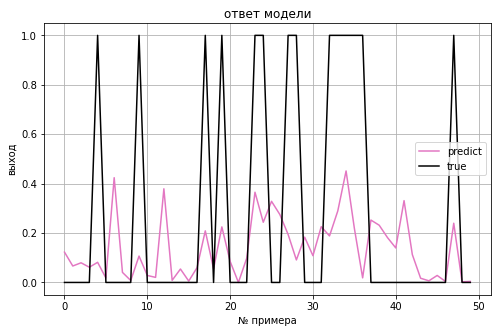

In [161]:
n = 50
plt.figure(figsize=(8, 5))
plt.plot(preds[:n], 'tab:pink', label='predict')
plt.plot(y_test.values[:n], 'k', label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [162]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f},\
      Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                 

Best Threshold=0.20338336001981705, F-Score=0.510,      Precision=0.391, Recall=0.733


In [163]:
roc_auc_score(y_test, preds)

0.863638888888889

## Таблица

In [164]:
table = {'': ['mean', 'median', 'max'],
     'F-Score': [0.510, np.nan , 0.510],
     'Precision': [0.415, 0, 0.391],
     'Recall': [0.660, 0, 0.733],
     'Roc_Auc': [0.880, 0.881, 0.864]}

df = pd.DataFrame(table)
df = df.style.hide_index()
df

,F-Score,Precision,Recall,Roc_Auc
mean,0.510000,0.415000,0.660000,0.880000
median,nan,0.000000,0.000000,0.881000
max,0.510000,0.391000,0.733000,0.864000


## Вывод 

Показатели на медиане (F-Score,	Precision, Recall) показывают что чисто математически не было срабатываний истинно положительных результатов. Опыт показал что из  трёх статистик самый информативный -  среднее арифметическое.